In [ ]:
!pip install pennylane


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 24.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 930.0/930.0 kB 45.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.3/15.3 MB 71.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 58.0 MB/s eta 0:00:00


In [ ]:
# Downgrade TensorFlow and Keras to a compatible version
!pip install tensorflow==2.10.0
!pip install keras==2.10.0


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 578.0/578.0 MB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 44.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.6/42.6 kB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 39.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.9/5.9 MB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 438.7/438.7 kB 29.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.9/4.9 MB 65.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 781.3/781.3 kB 41.9 MB/s eta 0:00:00
  Attempting uninstall: keras
    Found existing installation: keras 3.4.1
    Uninstalling keras-3.4.1:
      Successfully uninstalled keras-3.4.1
  Attempting uninstall: tensorboard-data-server
    Found existing installation: tensorboard-data-server 0.7.2
    Uninstalling tensorboard-data-server-0.7.2:
      Successfully uninstalled tensorboard-data-server-0.7.2
  At

Epoch 1/5
844/844 [==============================] - 51s 57ms/step - loss: 0.1844 - accuracy: 0.9434 - val_loss: 0.0528 - val_accuracy: 0.9852
Epoch 2/5
844/844 [==============================] - 48s 57ms/step - loss: 0.0537 - accuracy: 0.9835 - val_loss: 0.0457 - val_accuracy: 0.9880
Epoch 3/5
844/844 [==============================] - 48s 57ms/step - loss: 0.0375 - accuracy: 0.9880 - val_loss: 0.0405 - val_accuracy: 0.9878
Epoch 4/5
844/844 [==============================] - 47s 56ms/step - loss: 0.0289 - accuracy: 0.9906 - val_loss: 0.0397 - val_accuracy: 0.9900
Epoch 5/5
313/313 [==============================] - 3s 9ms/step - loss: 0.0327 - accuracy: 0.9885
CNN Test Accuracy: 0.9884999990463257


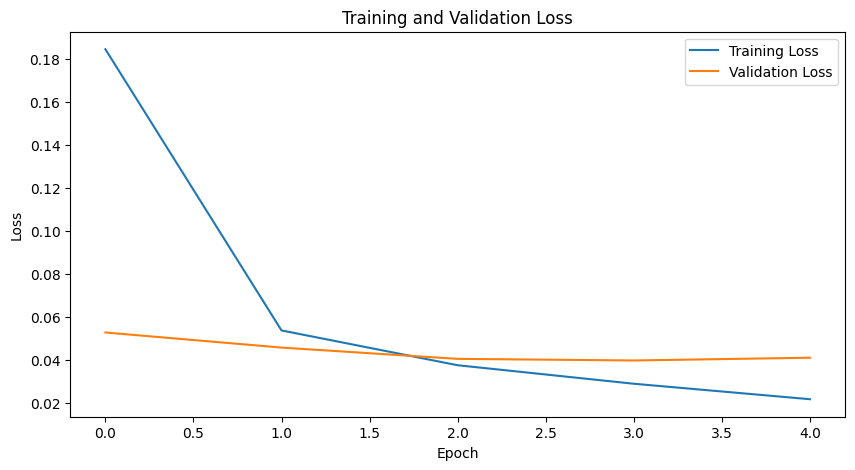

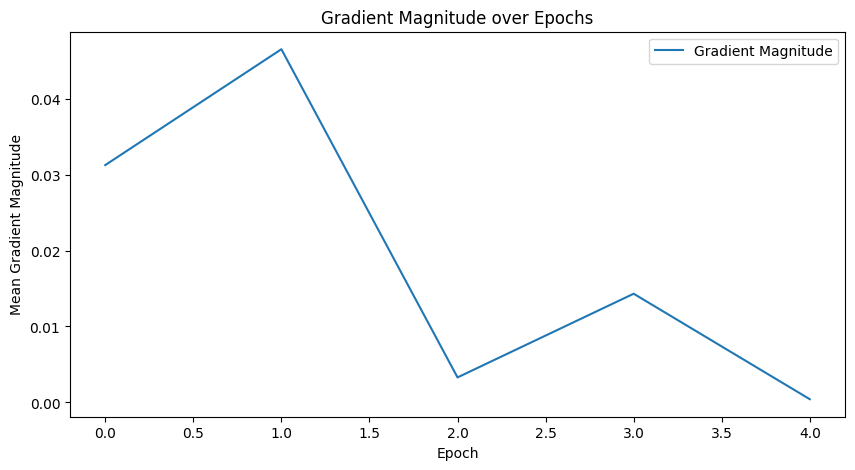

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import numpy as np

# Load MNIST data
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train, x_test = x_train[..., np.newaxis] / 255.0, x_test[..., np.newaxis] / 255.0  # Normalize and add channel dimension

# Define CNN architecture
def create_cnn():
    model = models.Sequential([
        layers.Conv2D(32, (3, 3), activation='relu', input_shape=(28, 28, 1)),
        layers.MaxPooling2D((2, 2)),
        layers.Conv2D(64, (3, 3), activation='relu'),
        layers.MaxPooling2D((2, 2)),
        layers.Flatten(),
        layers.Dense(64, activation='relu'),
        layers.Dense(10, activation='softmax')
    ])
    return model

cnn_model = create_cnn()
cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Custom callback to track loss and gradient magnitudes
class LossAndGradientCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.gradient_magnitudes = []

    def on_epoch_end(self, epoch, logs=None):
        # Record loss
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])

        # Calculate gradient magnitudes
        with tf.GradientTape() as tape:
            y_pred = cnn_model(x_train[:100], training=True)  # Small batch to estimate gradients
            loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_train[:100], y_pred))

        grads = tape.gradient(loss, cnn_model.trainable_weights)
        grad_magnitude = np.mean([tf.reduce_sum(tf.square(g)).numpy() for g in grads if g is not None])
        self.gradient_magnitudes.append(grad_magnitude)

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()

    def plot_gradient_magnitude(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.gradient_magnitudes, label='Gradient Magnitude')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Gradient Magnitude')
        plt.legend()
        plt.title('Gradient Magnitude over Epochs')
        plt.show()

# Instantiate and use the callback
loss_grad_callback = LossAndGradientCallback()
cnn_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[loss_grad_callback])

# Evaluate and print final accuracy
cnn_accuracy = cnn_model.evaluate(x_test, y_test)[1]
print(f"CNN Test Accuracy: {cnn_accuracy}")

# Plot Loss and Gradient Magnitude
loss_grad_callback.plot_loss()
loss_grad_callback.plot_gradient_magnitude()


Epoch 1/5
844/844 [==============================] - 161s 190ms/step - loss: 2.2866 - accuracy: 0.1352 - val_loss: 2.2440 - val_accuracy: 0.1762
Epoch 2/5
844/844 [==============================] - 158s 188ms/step - loss: 2.2001 - accuracy: 0.1876 - val_loss: 2.1505 - val_accuracy: 0.1855
Epoch 3/5
844/844 [==============================] - 161s 191ms/step - loss: 2.1348 - accuracy: 0.2007 - val_loss: 2.0945 - val_accuracy: 0.2027
Epoch 4/5
844/844 [==============================] - 162s 192ms/step - loss: 2.0960 - accuracy: 0.2162 - val_loss: 2.0599 - val_accuracy: 0.2313
Epoch 5/5
313/313 [==============================] - 30s 96ms/step - loss: 2.0663 - accuracy: 0.2380
QCNN Test Accuracy: 0.23800000548362732


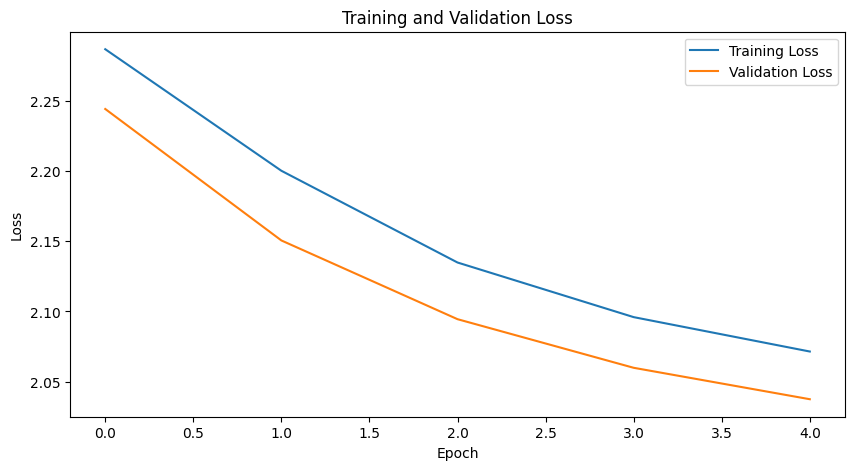

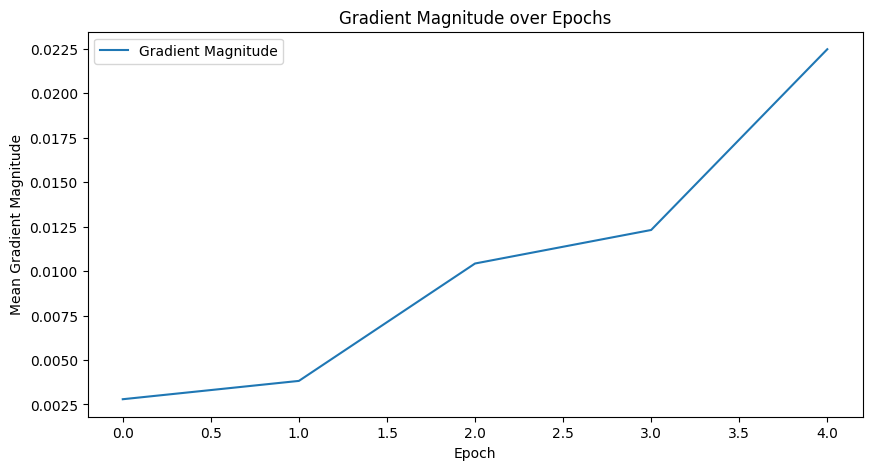

In [ ]:
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data
x_train = np.expand_dims(x_train, axis=-1)  # Add channel dimension
x_test = np.expand_dims(x_test, axis=-1)

# Downsample the MNIST images for quantum encoding (e.g., 2x2)
def downsample_image(image):
    image = tf.image.resize(image, (2, 2))  # Resize to 2x2 for 4 features
    return image.numpy().flatten()  # Flatten the image to a 1D array

# Quantum layer using PennyLane
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# QCNN model definition
def create_qcnn(n_layers=2):
    inputs = tf.keras.layers.Input(shape=(4,))  # Input shape of 4 for 4 qubits
    weight_shapes = {"weights": (n_layers, n_qubits)}
    qlayer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)
    x = qlayer(inputs)  # Connect directly to the quantum layer
    x = tf.keras.layers.Dense(10, activation='softmax')(x)  # Final dense layer for classification
    return tf.keras.models.Model(inputs=inputs, outputs=x)

# Preprocess the data for the quantum model
x_train_qcnn = np.array([downsample_image(img) for img in x_train])
x_test_qcnn = np.array([downsample_image(img) for img in x_test])

# Custom callback to track loss and gradient magnitudes
class LossAndGradientCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.gradient_magnitudes = []

    def on_epoch_end(self, epoch, logs=None):
        # Record loss and validation loss
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])

        # Calculate gradient magnitudes
        with tf.GradientTape() as tape:
            y_pred = self.model(x_train_qcnn[:100], training=True)  # Small batch to estimate gradients
            loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_train[:100], y_pred))

        grads = tape.gradient(loss, self.model.trainable_weights)
        grad_magnitude = np.mean([tf.reduce_sum(tf.square(g)).numpy() for g in grads if g is not None])
        self.gradient_magnitudes.append(grad_magnitude)

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()

    def plot_gradient_magnitude(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.gradient_magnitudes, label='Gradient Magnitude')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Gradient Magnitude')
        plt.legend()
        plt.title('Gradient Magnitude over Epochs')
        plt.show()

# Initialize and compile the QCNN model
qcnn_model = create_qcnn()
qcnn_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Instantiate and use the callback
loss_grad_callback = LossAndGradientCallback()
qcnn_model.fit(x_train_qcnn, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[loss_grad_callback])

# Evaluate and print final accuracy
qcnn_accuracy = qcnn_model.evaluate(x_test_qcnn, y_test)[1]
print(f"QCNN Test Accuracy: {qcnn_accuracy}")

# Plot Loss and Gradient Magnitude
loss_grad_callback.plot_loss()
loss_grad_callback.plot_gradient_magnitude()


Epoch 1/5
844/844 [==============================] - 220s 260ms/step - loss: 1.5579 - accuracy: 0.4299 - val_loss: 1.2257 - val_accuracy: 0.5667
Epoch 2/5
844/844 [==============================] - 206s 244ms/step - loss: 1.0918 - accuracy: 0.5352 - val_loss: 0.9762 - val_accuracy: 0.5677
Epoch 3/5
844/844 [==============================] - 207s 246ms/step - loss: 0.9129 - accuracy: 0.6032 - val_loss: 0.8208 - val_accuracy: 0.6685
Epoch 4/5
844/844 [==============================] - 209s 247ms/step - loss: 0.7811 - accuracy: 0.6724 - val_loss: 0.7236 - val_accuracy: 0.6932
Epoch 5/5
313/313 [==============================] - 31s 99ms/step - loss: 0.6851 - accuracy: 0.7265
Hybrid Model Test Accuracy: 0.7264999747276306


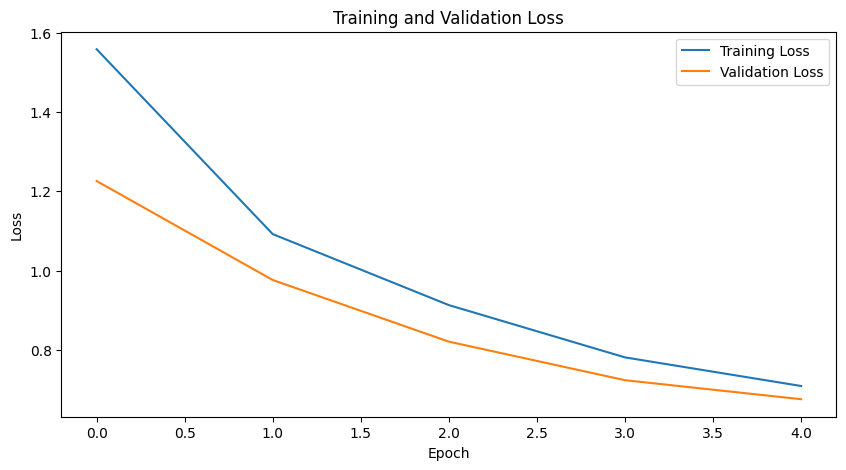

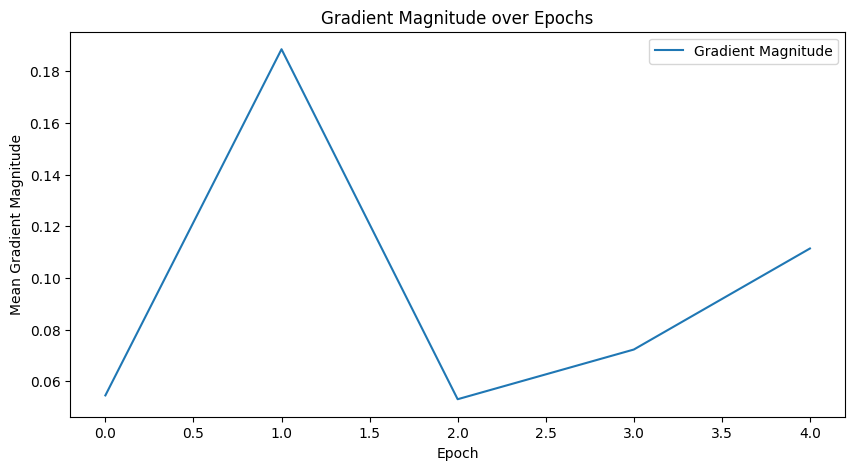

In [ ]:
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Quantum device and circuit
n_qubits = 4
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Hybrid model definition
def create_hybrid_model(n_layers=2):
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(4, activation='relu')(x)

    weight_shapes = {"weights": (n_layers, n_qubits)}
    qlayer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)
    x = qlayer(x)

    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x)

# Custom callback to track loss and gradient magnitudes
class LossAndGradientCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.gradient_magnitudes = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])

        with tf.GradientTape() as tape:
            y_pred = self.model(x_train[:100], training=True)  # Small batch for gradients
            loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_train[:100], y_pred))

        grads = tape.gradient(loss, self.model.trainable_weights)
        grad_magnitude = np.mean([tf.reduce_sum(tf.square(g)).numpy() for g in grads if g is not None])
        self.gradient_magnitudes.append(grad_magnitude)

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()

    def plot_gradient_magnitude(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.gradient_magnitudes, label='Gradient Magnitude')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Gradient Magnitude')
        plt.legend()
        plt.title('Gradient Magnitude over Epochs')
        plt.show()

# Initialize and compile the hybrid model
hybrid_model = create_hybrid_model()
hybrid_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Instantiate and use the callback
loss_grad_callback = LossAndGradientCallback()
hybrid_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[loss_grad_callback])

# Evaluate and print final accuracy
hybrid_accuracy = hybrid_model.evaluate(x_test, y_test)[1]
print(f"Hybrid Model Test Accuracy: {hybrid_accuracy}")

# Plot Loss and Gradient Magnitude
loss_grad_callback.plot_loss()
loss_grad_callback.plot_gradient_magnitude()


Epoch 1/5
844/844 [==============================] - 322s 382ms/step - loss: 1.6380 - accuracy: 0.3364 - val_loss: 1.2119 - val_accuracy: 0.4032
Epoch 2/5
844/844 [==============================] - 311s 368ms/step - loss: 1.1148 - accuracy: 0.4908 - val_loss: 1.0224 - val_accuracy: 0.5350
Epoch 3/5
844/844 [==============================] - 315s 374ms/step - loss: 1.0036 - accuracy: 0.5533 - val_loss: 0.9458 - val_accuracy: 0.5828
Epoch 4/5
844/844 [==============================] - 313s 371ms/step - loss: 0.9082 - accuracy: 0.6296 - val_loss: 0.8340 - val_accuracy: 0.6717
Epoch 5/5
313/313 [==============================] - 47s 151ms/step - loss: 0.7556 - accuracy: 0.7622
Hybrid Model Test Accuracy: 0.7621999979019165


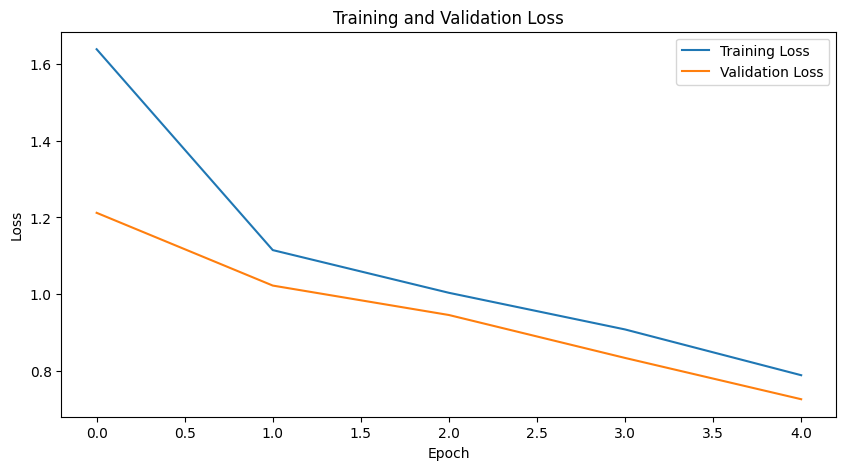

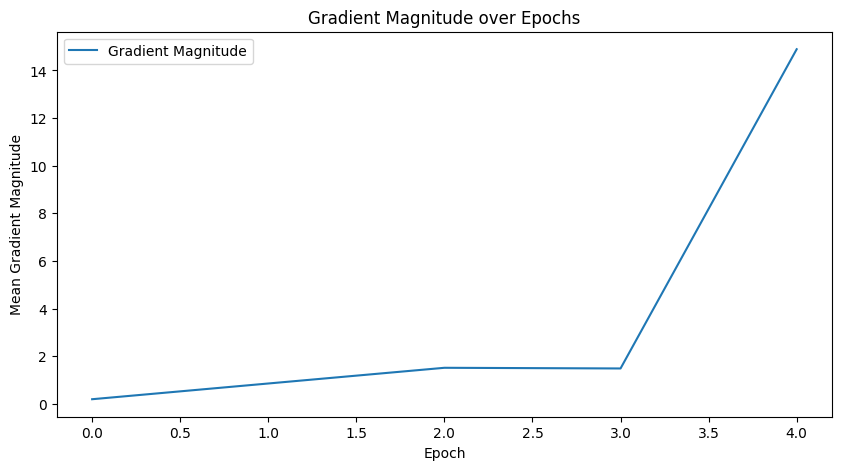

In [ ]:
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Quantum device with 6 qubits
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Hybrid model with 6 qubits
def create_hybrid_model(n_layers=2):
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(6, activation='relu')(x)  # Adjust for 6 features

    weight_shapes = {"weights": (n_layers, n_qubits)}
    qlayer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)
    x = qlayer(x)

    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x)

# Custom callback to track loss and gradient magnitudes
class LossAndGradientCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.gradient_magnitudes = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])

        with tf.GradientTape() as tape:
            y_pred = self.model(x_train[:100], training=True)  # Small batch for gradients
            loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_train[:100], y_pred))

        grads = tape.gradient(loss, self.model.trainable_weights)






                plt.figure(figsize=(10, 5))
        plt.plot(self.gradient_magnitudes, label='Gradient Magnitude')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Gradient Magnitude')
        plt.legend()
        plt.title('Gradient Magnitude over Epochs')
        plt.show()

# Initialize and compile the hybrid model
hybrid_model = create_hybrid_model()
hybrid_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Instantiate and use the callback
loss_grad_callback = LossAndGradientCallback()
hybrid_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[loss_grad_callback])

# Evaluate and print final accuracy
hybrid_accuracy = hybrid_model.evaluate(x_test, y_test)[1]
print(f"Hybrid Model Test Accuracy: {hybrid_accuracy}")

# Plot Loss and Gradient Magnitude
loss_grad_callback.plot_loss()
loss_grad_callback.plot_gradient_magnitude()


11490434/11490434 [==============================] - 0s 0us/step
Epoch 1/5
844/844 [==============================] - 475s 562ms/step - loss: 1.3671 - accuracy: 0.4954 - val_loss: 0.9270 - val_accuracy: 0.6207
Epoch 2/5
844/844 [==============================] - 459s 544ms/step - loss: 0.8775 - accuracy: 0.6616 - val_loss: 0.7711 - val_accuracy: 0.7347
Epoch 3/5
844/844 [==============================] - 459s 543ms/step - loss: 0.6824 - accuracy: 0.8052 - val_loss: 0.5572 - val_accuracy: 0.8497
Epoch 4/5
844/844 [==============================] - 460s 546ms/step - loss: 0.5083 - accuracy: 0.8723 - val_loss: 0.4064 - val_accuracy: 0.9265
Epoch 5/5
313/313 [==============================] - 66s 212ms/step - loss: 0.3267 - accuracy: 0.9332
Hybrid Model Test Accuracy: 0.9332000017166138


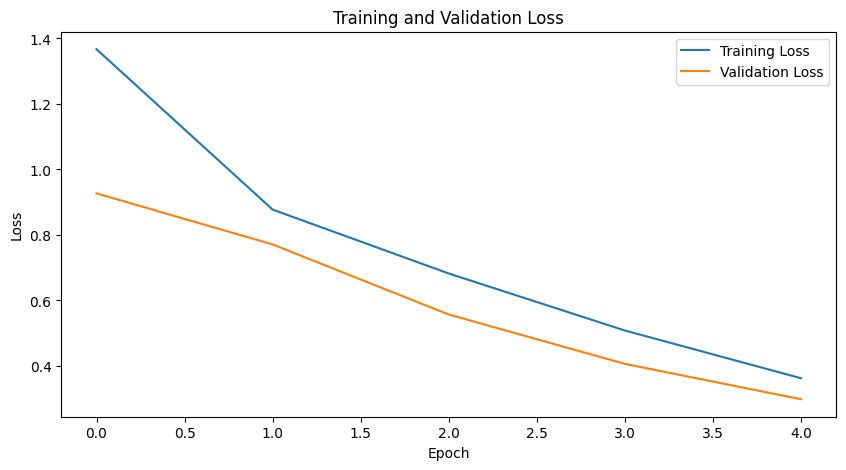

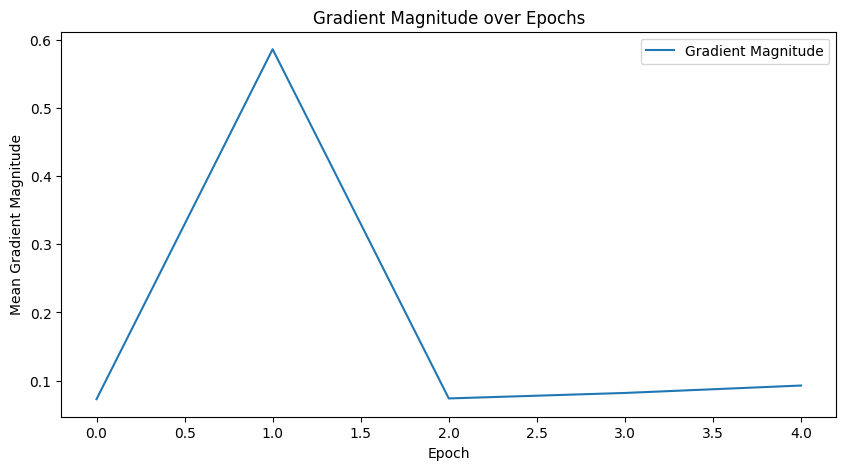

In [ ]:
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Quantum device with 6 qubits
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.BasicEntanglerLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Hybrid model with 6 qubits and increased quantum layers
def create_hybrid_model(n_layers=4):
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(n_qubits, activation='relu')(x)

    weight_shapes = {"weights": (n_layers, n_qubits)}
    qlayer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)
    x = qlayer(x)

    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x)

# Custom callback for tracking loss and gradient magnitudes
class LossAndGradientCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.gradient_magnitudes = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])

        # Compute gradient magnitudes
        with tf.GradientTape() as tape:
            y_pred = self.model(x_train[:100], training=True)  # Small batch for gradients
            loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_train[:100], y_pred))

        grads = tape.gradient(loss, self.model.trainable_weights)
        grad_magnitude = np.mean([tf.reduce_sum(tf.square(g)).numpy() for g in grads if g is not None])
        self.gradient_magnitudes.append(grad_magnitude)

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()

    def plot_gradient_magnitude(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.gradient_magnitudes, label='Gradient Magnitude')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Gradient Magnitude')
        plt.legend()
        plt.title('Gradient Magnitude over Epochs')
        plt.show()

# Initialize and compile the hybrid model
hybrid_model = create_hybrid_model()
hybrid_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Instantiate and use the callback
loss_grad_callback = LossAndGradientCallback()
hybrid_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[loss_grad_callback])

# Evaluate and print final accuracy
hybrid_accuracy = hybrid_model.evaluate(x_test, y_test)[1]
print(f"Hybrid Model Test Accuracy: {hybrid_accuracy}")

# Plot Loss and Gradient Magnitude
loss_grad_callback.plot_loss()
loss_grad_callback.plot_gradient_magnitude()


Epoch 1/5
844/844 [==============================] - 673s 796ms/step - loss: 1.0945 - accuracy: 0.7027 - val_loss: 0.5598 - val_accuracy: 0.8623
Epoch 2/5
844/844 [==============================] - 673s 798ms/step - loss: 0.4659 - accuracy: 0.8879 - val_loss: 0.3419 - val_accuracy: 0.9153
Epoch 3/5
844/844 [==============================] - 674s 799ms/step - loss: 0.3228 - accuracy: 0.9219 - val_loss: 0.2602 - val_accuracy: 0.9373
Epoch 4/5
844/844 [==============================] - 662s 784ms/step - loss: 0.2602 - accuracy: 0.9345 - val_loss: 0.2105 - val_accuracy: 0.9445
Epoch 5/5
313/313 [==============================] - 89s 285ms/step - loss: 0.2165 - accuracy: 0.9408
Hybrid Model Test Accuracy: 0.9408000111579895


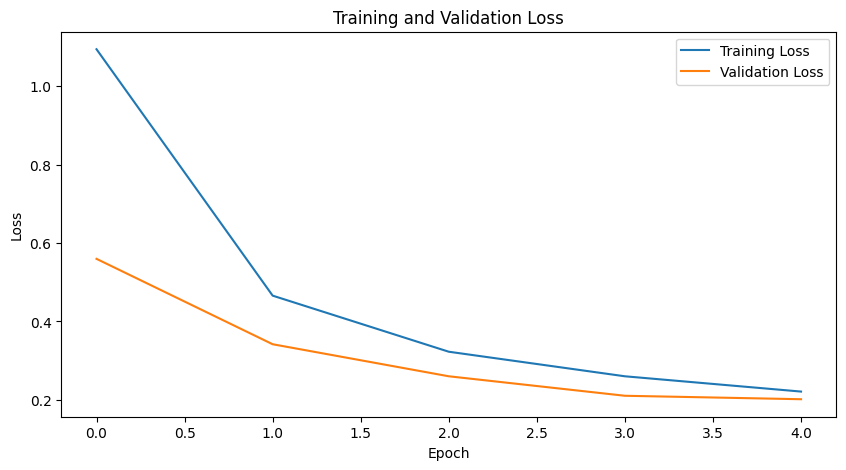

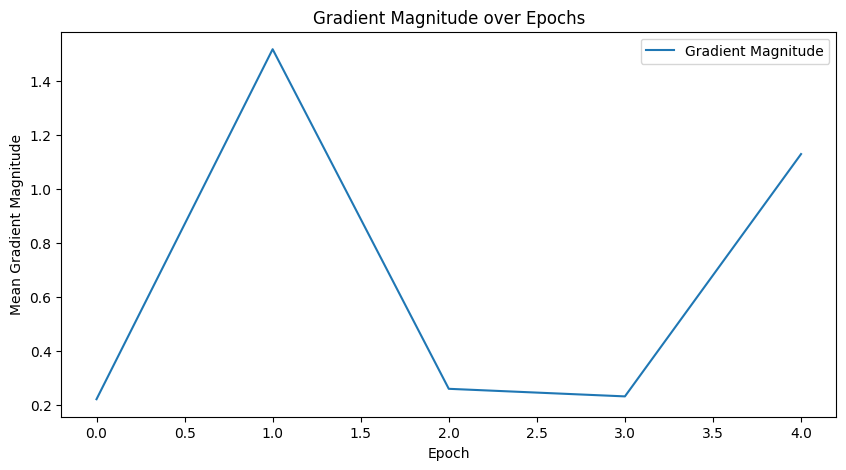

In [ ]:
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Quantum device with 6 qubits
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit with Strongly Entangling Layers design
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Hybrid quantum-classical model
def create_hybrid_model(n_layers=4):
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(n_qubits, activation='relu')(x)  # Match to 6 qubits

    # Quantum layer with Strongly Entangling Layers
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    qlayer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)
    x = qlayer(x)

    # Classical output layer
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x)

# Callback for loss and gradient magnitude
class LossAndGradientCallback(tf.keras.callbacks.Callback):
    def __init__(self):
        super().__init__()
        self.losses = []
        self.val_losses = []
        self.gradient_magnitudes = []

    def on_epoch_end(self, epoch, logs=None):
        self.losses.append(logs['loss'])
        self.val_losses.append(logs['val_loss'])

        # Calculate gradient magnitudes for tracking
        with tf.GradientTape() as tape:
            y_pred = self.model(x_train[:100], training=True)  # Use small sample for efficiency
            loss = tf.reduce_mean(tf.keras.losses.sparse_categorical_crossentropy(y_train[:100], y_pred))

        grads = tape.gradient(loss, self.model.trainable_weights)
        grad_magnitude = np.mean([tf.reduce_sum(tf.square(g)).numpy() for g in grads if g is not None])
        self.gradient_magnitudes.append(grad_magnitude)

    def plot_loss(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.losses, label='Training Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()
        plt.title('Training and Validation Loss')
        plt.show()

    def plot_gradient_magnitude(self):
        plt.figure(figsize=(10, 5))
        plt.plot(self.gradient_magnitudes, label='Gradient Magnitude')
        plt.xlabel('Epoch')
        plt.ylabel('Mean Gradient Magnitude')
        plt.legend()
        plt.title('Gradient Magnitude over Epochs')
        plt.show()

# Initialize and compile the hybrid model
hybrid_model = create_hybrid_model()
hybrid_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Instantiate and use the callback
loss_grad_callback = LossAndGradientCallback()
hybrid_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[loss_grad_callback])

# Evaluate and print final accuracy
hybrid_accuracy = hybrid_model.evaluate(x_test, y_test)[1]
print(f"Hybrid Model Test Accuracy: {hybrid_accuracy}")

# Plot Loss and Gradient Magnitude
loss_grad_callback.plot_loss()
loss_grad_callback.plot_gradient_magnitude()


Epoch 1/5
844/844 [==============================] - 999s 1s/step - loss: 1.1929 - accuracy: 0.6689 - val_loss: 0.6506 - val_accuracy: 0.8372
Epoch 2/5
844/844 [==============================] - 934s 1s/step - loss: 0.5669 - accuracy: 0.8401 - val_loss: 0.4215 - val_accuracy: 0.8748
Epoch 3/5
844/844 [==============================] - 938s 1s/step - loss: 0.4216 - accuracy: 0.8742 - val_loss: 0.3567 - val_accuracy: 0.8787
Epoch 4/5
844/844 [==============================] - 935s 1s/step - loss: 0.3450 - accuracy: 0.9071 - val_loss: 0.2849 - val_accuracy: 0.9355
Epoch 5/5
313/313 [==============================] - 118s 377ms/step - loss: 0.2599 - accuracy: 0.9413
Hybrid Model Test Accuracy: 0.9412999749183655


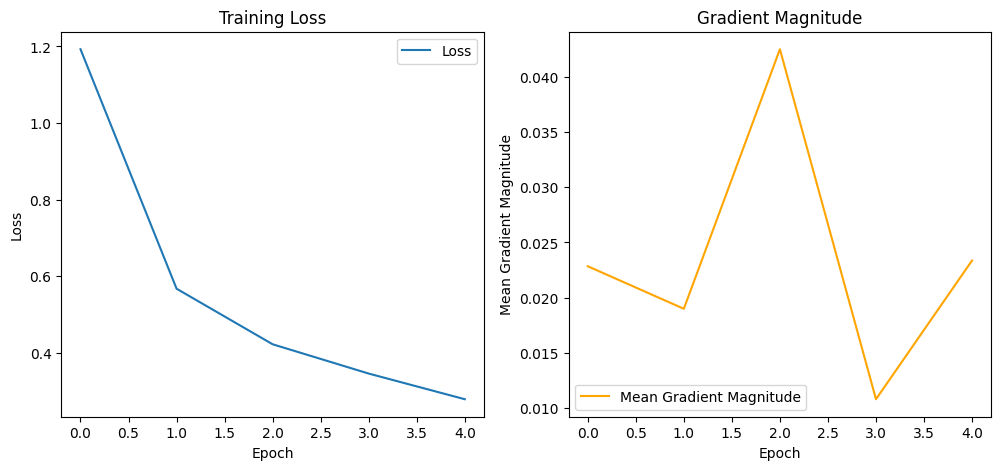

In [ ]:
import tensorflow as tf
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import mnist

# Load and preprocess MNIST data
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train, x_test = x_train / 255.0, x_test / 255.0  # Normalize data
x_train = np.expand_dims(x_train, axis=-1)
x_test = np.expand_dims(x_test, axis=-1)

# Define a quantum device with 6 qubits
n_qubits = 6
dev = qml.device("default.qubit", wires=n_qubits)

# Quantum circuit with a Strongly Entangling Layers design
@qml.qnode(dev)
def quantum_circuit(inputs, weights):
    qml.templates.AngleEmbedding(inputs, wires=range(n_qubits))
    qml.templates.StronglyEntanglingLayers(weights, wires=range(n_qubits))
    return [qml.expval(qml.PauliZ(i)) for i in range(n_qubits)]

# Define the hybrid quantum-classical model
def create_hybrid_model(n_layers=6):
    # Classical feature extraction layers
    inputs = tf.keras.layers.Input(shape=(28, 28, 1))
    x = tf.keras.layers.Conv2D(32, (3, 3), activation='relu')(inputs)
    x = tf.keras.layers.MaxPooling2D((2, 2))(x)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(n_qubits, activation='relu')(x)  # Match qubit count for quantum layer

    # Quantum layer with Strongly Entangling Layers
    weight_shapes = {"weights": (n_layers, n_qubits, 3)}
    qlayer = qml.qnn.KerasLayer(quantum_circuit, weight_shapes, output_dim=n_qubits)
    x = qlayer(x)

    # Classical output layer
    x = tf.keras.layers.Dense(10, activation='softmax')(x)
    return tf.keras.models.Model(inputs=inputs, outputs=x)

# Custom callback to track loss and gradient magnitude
class LossGradientLogger(tf.keras.callbacks.Callback):
    def __init__(self, validation_data):
        super().__init__()
        self.validation_data = validation_data
        self.losses = []
        self.mean_gradients = []

    def on_epoch_end(self, epoch, logs=None):
        # Record loss
        self.losses.append(logs["loss"])

        # Calculate gradient magnitude
        x_val, y_val = self.validation_data

        # Convert y_val to a TensorFlow tensor to avoid 'AttributeError'
        y_val = tf.convert_to_tensor(y_val)

        with tf.GradientTape() as tape:
            # Perform forward pass and calculate loss
            y_pred = self.model(x_val, training=True)
            loss = self.model.compiled_loss(y_val, y_pred, regularization_losses=self.model.losses)

        # Calculate gradients and their mean magnitude
        grads = tape.gradient(loss, self.model.trainable_weights)
        mean_grad = np.mean([np.mean(np.abs(grad)) for grad in grads if grad is not None])
        self.mean_gradients.append(mean_grad)

# Initialize the hybrid model and compile it
hybrid_model = create_hybrid_model()
hybrid_model.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["accuracy"])

# Initialize the callback with validation data
logger = LossGradientLogger(validation_data=(x_test, y_test))

# Train the model
hybrid_model.fit(x_train, y_train, epochs=5, batch_size=64, validation_split=0.1, callbacks=[logger])

# Evaluate model accuracy
hybrid_accuracy = hybrid_model.evaluate(x_test, y_test)[1]
print(f"Hybrid Model Test Accuracy: {hybrid_accuracy}")

# Plot the loss and mean gradient magnitude
plt.figure(figsize=(12, 5))

# Loss plot
plt.subplot(1, 2, 1)
plt.plot(logger.losses, label="Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.legend()

# Mean gradient magnitude plot
plt.subplot(1, 2, 2)
plt.plot(logger.mean_gradients, label="Mean Gradient Magnitude", color='orange')
plt.xlabel("Epoch")
plt.ylabel("Mean Gradient Magnitude")
plt.title("Gradient Magnitude")
plt.legend()

plt.show()
